# CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN

This project comes from the pytorch documentation [here](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).



In [18]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

def find_files(path): return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language.
category_lines = {}
all_categories = []

# Read a file and split into lines.
def read_lines(filename):
    with open(filename, encoding='utf-8') as file:
        lines = file.read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in find_files('../../data/names-dataset/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)


In [22]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_idx(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor.
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_idx(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-host letter vectors.
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_idx(letter)] = 1
    return tensor
    

In [24]:
print(letter_to_tensor('J').size())
print(line_to_tensor('Jones').size())

torch.Size([1, 57])
torch.Size([5, 1, 57])


In [26]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)



In [27]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)


In [31]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
output

tensor([[-2.8138, -2.9229, -2.8595, -2.9003, -2.8003, -2.9038, -2.9249, -2.9062,
         -2.9421, -2.8794, -2.8949, -2.9707, -2.8916, -2.9020, -2.8834, -2.7889,
         -2.8675, -2.9993]], grad_fn=<LogSoftmaxBackward>)

In [32]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
    

In [33]:
print(category_from_output(output))

('Dutch', 15)


In [34]:
import random

def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_example():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor


In [35]:
# Testing above code.
for i in range(10):
    category, line, category_tensor, line_tensor = random_training_example()
    print('category=', category, '/ line =', line)
    

category= Vietnamese / line = Quang
category= Irish / line = Teagan
category= Dutch / line = Spijker
category= Korean / line = Ra
category= Russian / line = Uemlyanin
category= Polish / line = Kava
category= Japanese / line = Aizawa
category= Japanese / line = Kamioka
category= German / line = Augustin
category= Korean / line = Tsai 


## Training the Network

In [37]:
criterion = nn.NLLLoss()


In [38]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Add parameters' gradients to their values, multiplied by learning rate.
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()
    

In [39]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print iter number, loss, name, and guess.
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses.
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
    
    

5000 5% (0m 8s) 2.8560 Fernandes / Greek ✗ (Portuguese)
10000 10% (0m 15s) 3.4284 Close / Irish ✗ (Greek)
15000 15% (0m 23s) 3.0635 Guirguis / Greek ✗ (Arabic)
20000 20% (0m 31s) 1.9718 Penfold / French ✗ (English)
25000 25% (0m 39s) 1.5117 Kitano / Japanese ✓
30000 30% (0m 46s) 0.8395 Tanuma / Japanese ✓
35000 35% (0m 54s) 0.0892 Chartorijsky / Russian ✓
40000 40% (1m 1s) 0.1688 Sklavenitis / Greek ✓
45000 45% (1m 9s) 1.3361 Rivero / Spanish ✓
50000 50% (1m 17s) 2.4280 Hatin / Korean ✗ (Russian)
55000 55% (1m 26s) 1.2435 Kong / Korean ✗ (Chinese)
60000 60% (1m 34s) 3.6984 Stabile / French ✗ (Italian)
65000 65% (1m 42s) 0.3662 Wan / Chinese ✓
70000 70% (1m 50s) 1.7395 Ramaaker / German ✗ (Dutch)
75000 75% (1m 57s) 0.2151 Batsakis / Greek ✓
80000 80% (2m 5s) 0.7127 Awramtchik / Russian ✓
85000 85% (2m 13s) 0.9064 Haanraats / Dutch ✓
90000 90% (2m 22s) 0.9814 Chin / Korean ✓
95000 95% (2m 29s) 3.7357 Agramunt / French ✗ (Spanish)
100000 100% (2m 37s) 2.1979 Koci / Italian ✗ (Czech)


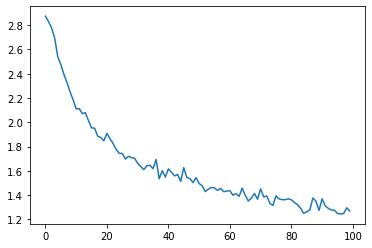

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


## Evaluating the Results

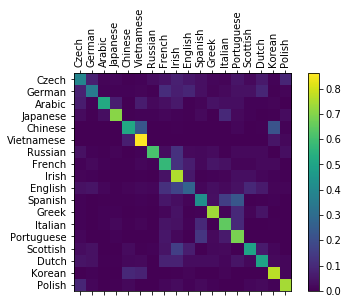

In [41]:
# Keep track of correct guesses in a confusion matrix.
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line.
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output

# Go through a bunch of examples and record which are correct guessed.
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
# Normalize by dividing every row by its sum.
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Set up plot.
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes.
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick.
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumnail_number = 2
plt.show()

    

## Predicting on User Input

In [45]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))
        
        # Get top n categories.
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


In [46]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.86) Russian
(-0.92) Czech
(-2.61) English

> Jackson
(-0.48) Scottish
(-1.21) English
(-3.48) Dutch

> Satoshi
(-0.96) Italian
(-1.09) Japanese
(-2.76) Arabic
